This notebook is a little easier for beginners because it uses pytorch. You need to clone a repo to get it working:

```sh
# you need this repo, so clone it
git clone https://github.com/wassname/DeepRL.git
cd DeepRL
git reset --hard aeae2c5d585e5853dc638968b1f090eb60abd351
cd ..
mkdir data log evaluation_log
```

This contains some minor modifications from https://github.com/ShangtongZhang/DeepRL.git

The notebook tries DPPG with the [EIIE model](https://arxiv.org/pdf/1706.10059.pdf)

I also uncommented reward normalization in DDPG_agent.py#L64 because otherwise my small reward les to large Q's, inf losses, and NaN actions and weights.

In [1]:
# plotting
%matplotlib notebook
from matplotlib import pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

# numeric
import numpy as np
from numpy import random
import pandas as pd

# utils
from tqdm import tqdm_notebook as tqdm
from collections import Counter
import tempfile
import logging
import time
import datetime

# logging
logger = log = logging.getLogger(__name__)
log.setLevel(logging.INFO)
logging.basicConfig()
log.info('%s logger started.', __name__)

INFO:__main__:__main__ logger started.


In [2]:
import os
os.sys.path.append(os.path.abspath('.'))
os.sys.path.append(os.path.abspath('DeepRL'))
%reload_ext autoreload
%autoreload 2

In [3]:
# params
window_length = 50
steps = 128



In [4]:
# save dir
import datetime
ts = datetime.datetime.utcnow().strftime('%Y%m%d_%H-%M-%S')

save_path = './outputs/pytorch-DDPG/pytorch-DDPG-EIIE-action-crypto-%s.model' % ts
save_path
try:
    os.makedirs(os.path.dirname(save_path))
except OSError:
    pass

In [5]:
# setup tensorboard logging
from tensorboard_logger import configure, log_value
tag = 'ddpg-' + ts
print('tensorboard --logdir '+"runs/" + tag)
try:
    configure("runs/" + tag)
except ValueError as e:
    print(e)
    pass

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


tensorboard --logdir runs/ddpg-20180218_06-06-08


# Env

In [6]:
from rl_portfolio_management.environments.portfolio import PortfolioEnv
from rl_portfolio_management.util import MDD, sharpe, softmax
from rl_portfolio_management.wrappers import SoftmaxActions, TransposeHistory, ConcatStates

df_train = pd.read_hdf('./data/poloniex_30m.hf',key='train')
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')


In [7]:
import gym
class DeepRLWrapper(gym.Wrapper):
    def __init__(self, env):
        super().__init__(env)
        self.render_on_reset = False
        
        self.state_dim = self.observation_space.shape
        self.action_dim = self.action_space.shape[0]
        
        self.name = 'PortfolioEnv'
        self.success_threshold = 2
        
    def normalize_state(self, state):
        return state
    
    def step(self, action):
        state, reward, done, info =self.env.step(action)
        reward*=1e4 # often reward scaling is important sooo...
        return state, reward, done, info
    
    def reset(self):        
        # here's a roundabout way to get it to plot on reset
        if self.render_on_reset: 
            self.env.render('notebook')

        return self.env.reset()

In [8]:
def task_fn():
    env = PortfolioEnv(df=df_train, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env

def task_fn_test():
    env = PortfolioEnv(df=df_test, steps=steps, output_mode='EIIE')
    env = TransposeHistory(env)
    env = ConcatStates(env)
    env = SoftmaxActions(env)
    env = DeepRLWrapper(env)
    return env
    
# sanity check
task = task_fn()
task.reset().shape, task.step(task.action_space.sample())[0].shape

((4, 51, 3), (4, 51, 3))

# Agent and models

In [9]:
# load
import pickle
import shutil

def save_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    agent.save(save_file)
    print(save_file)
    

def load_ddpg(agent):
    agent_type = agent.__class__.__name__
    save_file = 'data/%s-%s-model-%s.bin' % (agent_type, config.tag, agent.task.name)
    new_states = pickle.load(open(save_file, 'rb'))
    states = agent.worker_network.load_state_dict(new_states)


def load_stats_ddpg(agent):
    agent_type = agent.__class__.__name__
    online_stats_file = 'data/%s-%s-online-stats-%s.bin' % (
                    agent_type, config.tag, agent.task.name)
    try:
        steps, rewards = pickle.load(open(online_stats_file, 'rb'))
    except FileNotFoundError:
        steps =[]
        rewards=[]
    df_online = pd.DataFrame(np.array([steps, rewards]).T, columns=['steps','rewards'])
    if len(df_online):
        df_online['step'] = df_online['steps'].cumsum()
        df_online.index.name = 'episodes'
    
    stats_file = 'data/%s-%s-all-stats-%s.bin' % (agent_type, config.tag, agent.task.name)
    try:
        stats = pickle.load(open(stats_file, 'rb'))
    except FileNotFoundError:
        stats = {}
    df = pd.DataFrame(stats["test_rewards"], columns=['rewards'])
    if len(df):
#         df["steps"]=range(len(df))*50

        df.index.name = 'episodes'
    return df_online, df

In [10]:
import logging
from agent import ProximalPolicyOptimization, DisjointActorCriticNet #, DeterministicActorNet, DeterministicCriticNet
from component import GaussianPolicy, HighDimActionReplay, OrnsteinUhlenbeckProcess
from utils import Config, Logger
import gym
import torch
gym.logger.setLevel(logging.INFO)

# Alg

In [11]:
# Modified from https://github.com/ShangtongZhang/DeepRL to log to tensorboard

from utils.normalizer import Normalizer

null_normaliser = lambda x:x

class DDPGAgent:
    def __init__(self, config):
        self.config = config
        self.task = config.task_fn()
        self.worker_network = config.network_fn()
        self.target_network = config.network_fn()
        self.target_network.load_state_dict(self.worker_network.state_dict())
        self.actor_opt = config.actor_optimizer_fn(self.worker_network.actor.parameters())
        self.critic_opt = config.critic_optimizer_fn(self.worker_network.critic.parameters())
        self.replay = config.replay_fn()
        self.random_process = config.random_process_fn()
        self.criterion = nn.MSELoss()
        self.total_steps = 0

        self.state_normalizer = Normalizer(self.task.state_dim) # null_normaliser # 
        self.reward_normalizer = Normalizer(1)

    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.data.copy_(target_param.data * (1.0 - self.config.target_network_mix) +
                                    param.data * self.config.target_network_mix)

    def save(self, file_name):
        with open(file_name, 'wb') as f:
            torch.save(self.worker_network.state_dict(), f)

    def episode(self, deterministic=False, video_recorder=None):
        self.random_process.reset_states()
        state = self.task.reset()
        state = self.state_normalizer(state)

        config = self.config
        actor = self.worker_network.actor
        critic = self.worker_network.critic
        target_actor = self.target_network.actor
        target_critic = self.target_network.critic

        steps = 0
        total_reward = 0.0
        while True:
            actor.eval()
            action = actor.predict(np.stack([state])).flatten()
            if not deterministic:
                action += self.random_process.sample()
            next_state, reward, done, info = self.task.step(action)
            if video_recorder is not None:
                video_recorder.capture_frame()
            done = (done or (config.max_episode_length and steps >= config.max_episode_length))
            next_state = self.state_normalizer(next_state) * config.reward_scaling
            total_reward += reward
            
            # tensorboard logging
            prefix = 'test_' if deterministic else ''
            log_value(prefix + 'reward', reward, self.total_steps)
#             log_value(prefix + 'action', action, steps)
            log_value('memory_size', self.replay.size(), self.total_steps)     
            for key in info:
                log_value(key, info[key], self.total_steps)     
            
            reward = self.reward_normalizer(reward)

            if not deterministic:
                self.replay.feed([state, action, reward, next_state, int(done)])
                self.total_steps += 1

            steps += 1
            state = next_state

            if done:
                break

            if not deterministic and self.replay.size() >= config.min_memory_size:
                self.worker_network.train()
                experiences = self.replay.sample()
                states, actions, rewards, next_states, terminals = experiences
                q_next = target_critic.predict(next_states, target_actor.predict(next_states))
                terminals = critic.to_torch_variable(terminals).unsqueeze(1)
                rewards = critic.to_torch_variable(rewards).unsqueeze(1)
                q_next = config.discount * q_next * (1 - terminals)
                q_next.add_(rewards)
                q_next = q_next.detach()
                q = critic.predict(states, actions)
                critic_loss = self.criterion(q, q_next)

                critic.zero_grad()
                self.critic_opt.zero_grad()
                critic_loss.backward()
                if config.gradient_clip:
                    grad_critic = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.critic_opt.step()

                actions = actor.predict(states, False)
                var_actions = Variable(actions.data, requires_grad=True)
                q = critic.predict(states, var_actions)
                q.backward(torch.ones(q.size()))

                actor.zero_grad()
                self.actor_opt.zero_grad()
                actions.backward(-var_actions.grad.data)
                if config.gradient_clip:
                    grad_actor = nn.utils.clip_grad_norm(self.worker_network.parameters(), config.gradient_clip)
                self.actor_opt.step()
                
                # tensorboard logging
                log_value('critic_loss', critic_loss.cpu().data.numpy().squeeze(), self.total_steps)
                log_value('loss_action', -q.sum(), self.total_steps)
                if config.gradient_clip:
                    log_value('grad_critic', grad_critic, self.total_steps)
                    log_value('grad_actor', grad_actor, self.total_steps)

                self.soft_update(self.target_network, self.worker_network)

        return total_reward, steps

# Model

In [12]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [13]:
task.state_dim, task.action_dim

((4, 51, 3), 4)

In [14]:

from network.base_network import BasicNet

class DeterministicActorNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 action_gate,
                 action_scale,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicActorNet, self).__init__()

        stride_time = state_dim[1] - 1 - 2 #
        features = task.state_dim[0]
        h0 = 2
        h1 = 30
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.conv3 = nn.Conv2d((h1+1), 1, (1, 1))

        self.action_scale = action_scale
        self.action_gate = action_gate
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)

        self.batch_norm = batch_norm
        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x):
        x = self.to_torch_variable(x)
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        action = self.conv3(h)
        
        # add cash_bias before we softmax
        cash_bias_int = 0
        cash_bias = self.to_torch_variable(torch.ones(action.size())[:,:,:,:1] * cash_bias_int)
        action = torch.cat([cash_bias, action], -1)
        
        batch_size = action.size()[0]
        action = action.view((batch_size,-1))
        if self.action_gate:
            action = self.action_scale * self.action_gate(action)
        return action

    def predict(self, x, to_numpy=True):
        y = self.forward(x)
        if to_numpy:
            y = y.cpu().data.numpy()
        return y

class DeterministicCriticNet(nn.Module, BasicNet):
    def __init__(self,
                 state_dim,
                 action_dim,
                 gpu=False,
                 batch_norm=False,
                 non_linear=F.relu):
        super(DeterministicCriticNet, self).__init__()
        stride_time = state_dim[1] - 1 - 2 #
        self.features = features = task.state_dim[0]
        h0=2
        h1=20
        self.action = actions = action_dim -1
        self.conv1 = nn.Conv2d(features, h0, (3, 1))
        self.conv2 = nn.Conv2d(h0, h1, (stride_time, 1), stride=(stride_time, 1))
        self.layer3 = nn.Linear((h1+2)*actions, 1)
        self.non_linear = non_linear

        if batch_norm:
            self.bn1 = nn.BatchNorm1d(h0)
            self.bn2 = nn.BatchNorm1d(h1)
        self.batch_norm = batch_norm

        BasicNet.__init__(self, None, gpu, False)


    def forward(self, x, action):
        x = self.to_torch_variable(x)
        action = self.to_torch_variable(action)[:,None,None,:-1] # remove cash bias
        
        w0 = x[:,:1,:1,:] # weights from last step 
        x = x[:,:,1:,:]
        
        phi0 = self.non_linear(self.conv1(x))
        if self.batch_norm:
            phi0 = self.bn1(phi0)
        phi1 = self.non_linear(self.conv2(phi0))
        h = torch.cat([phi1,w0,action], 1)
        if self.batch_norm:
            h = self.bn2(h)
        
        batch_size = x.size()[0]
        action = self.layer3(h.view((batch_size,-1)))
        return action

    def predict(self, x, action):
        return self.forward(x, action)

# Config

In [15]:
config = Config()
config.task_fn = task_fn
task = config.task_fn()
config.actor_network_fn = lambda: DeterministicActorNet(
    task.state_dim, task.action_dim, action_gate=None, action_scale=1.0, non_linear=F.relu, batch_norm=False, gpu=False)
config.critic_network_fn = lambda: DeterministicCriticNet(
    task.state_dim, task.action_dim, non_linear=F.relu, batch_norm=False, gpu=False)
config.network_fn = lambda: DisjointActorCriticNet(config.actor_network_fn, config.critic_network_fn)
config.actor_optimizer_fn = lambda params: torch.optim.Adam(params, lr=4e-5)
config.critic_optimizer_fn =\
    lambda params: torch.optim.Adam(params, lr=5e-4, weight_decay=0.001)
config.replay_fn = lambda: HighDimActionReplay(memory_size=600, batch_size=64)
config.random_process_fn = \
    lambda: OrnsteinUhlenbeckProcess(size=task.action_dim, theta=0.15, sigma=0.2, sigma_min=0.00002, n_steps_annealing=10000)
config.discount = 0.0

config.min_memory_size = 50
config.target_network_mix = 0.001
config.max_steps = 300000
config.max_episode_length = 3000
config.target_network_mix = 0.01
config.noise_decay_interval = 100000
config.gradient_clip = 20
config.min_epsilon = 0.1

# Many papers have found rewards scaling to be an important parameter. But while they focus on the scaling factor
# I think they should focus on the end variance with a range of 200-400. e.g. https://arxiv.org/pdf/1709.06560.pdf
# Hard to tell for sure without experiments to prove it
config.reward_scaling = 1000

config.test_interval = 10
config.test_repetitions = 1
config.save_interval = 40
config.logger = Logger('./log', gym.logger)
config.tag = tag
agent = DDPGAgent(config)
agent

# Train

In [16]:
from main import run_episodes
agent.task._plot = agent.task._plot2 = None
try:    
    run_episodes(agent)
except KeyboardInterrupt as e:
    save_ddpg(agent)
    raise(e)

INFO:gym:episode 1, reward -27.754773, avg reward -27.754773, total steps 128, episode step 128
[2018-02-18 14:06:13,642] episode 1, reward -27.754773, avg reward -27.754773, total steps 128, episode step 128
INFO:gym:episode 2, reward -38.238554, avg reward -32.996664, total steps 256, episode step 128
[2018-02-18 14:06:16,083] episode 2, reward -38.238554, avg reward -32.996664, total steps 256, episode step 128
INFO:gym:episode 3, reward -44.410998, avg reward -36.801442, total steps 384, episode step 128
[2018-02-18 14:06:18,260] episode 3, reward -44.410998, avg reward -36.801442, total steps 384, episode step 128
INFO:gym:episode 4, reward -23.274828, avg reward -33.419788, total steps 512, episode step 128
[2018-02-18 14:06:20,447] episode 4, reward -23.274828, avg reward -33.419788, total steps 512, episode step 128
INFO:gym:episode 5, reward -5.559020, avg reward -27.847635, total steps 640, episode step 128
[2018-02-18 14:06:22,493] episode 5, reward -5.559020, avg reward -27

INFO:gym:episode 38, reward -1.535611, avg reward -4.673023, total steps 4864, episode step 128
[2018-02-18 14:07:43,443] episode 38, reward -1.535611, avg reward -4.673023, total steps 4864, episode step 128
INFO:gym:episode 39, reward 0.052444, avg reward -4.551857, total steps 4992, episode step 128
[2018-02-18 14:07:46,402] episode 39, reward 0.052444, avg reward -4.551857, total steps 4992, episode step 128
INFO:gym:episode 40, reward -0.321126, avg reward -4.446089, total steps 5120, episode step 128
[2018-02-18 14:07:48,800] episode 40, reward -0.321126, avg reward -4.446089, total steps 5120, episode step 128
INFO:gym:Testing...
[2018-02-18 14:07:48,801] Testing...
INFO:gym:Avg reward 0.055954(0.000000)
[2018-02-18 14:07:49,215] Avg reward 0.055954(0.000000)
INFO:gym:episode 41, reward -0.378356, avg reward -4.346876, total steps 5248, episode step 128
[2018-02-18 14:07:51,334] episode 41, reward -0.378356, avg reward -4.346876, total steps 5248, episode step 128
INFO:gym:episo

[2018-02-18 14:09:08,689] episode 74, reward -0.415954, avg reward -2.476575, total steps 9472, episode step 128
INFO:gym:episode 75, reward 0.167118, avg reward -2.441326, total steps 9600, episode step 128
[2018-02-18 14:09:10,755] episode 75, reward 0.167118, avg reward -2.441326, total steps 9600, episode step 128
INFO:gym:episode 76, reward -0.026937, avg reward -2.409558, total steps 9728, episode step 128
[2018-02-18 14:09:12,817] episode 76, reward -0.026937, avg reward -2.409558, total steps 9728, episode step 128
INFO:gym:episode 77, reward -0.374907, avg reward -2.383134, total steps 9856, episode step 128
[2018-02-18 14:09:14,950] episode 77, reward -0.374907, avg reward -2.383134, total steps 9856, episode step 128
INFO:gym:episode 78, reward -0.555474, avg reward -2.359702, total steps 9984, episode step 128
[2018-02-18 14:09:17,133] episode 78, reward -0.555474, avg reward -2.359702, total steps 9984, episode step 128
INFO:gym:episode 79, reward -0.409236, avg reward -2.

INFO:gym:Avg reward -0.297198(0.000000)
[2018-02-18 14:10:33,251] Avg reward -0.297198(0.000000)
INFO:gym:episode 111, reward -0.016000, avg reward -0.360825, total steps 14208, episode step 128
[2018-02-18 14:10:35,412] episode 111, reward -0.016000, avg reward -0.360825, total steps 14208, episode step 128
INFO:gym:episode 112, reward -0.080619, avg reward -0.353750, total steps 14336, episode step 128
[2018-02-18 14:10:37,926] episode 112, reward -0.080619, avg reward -0.353750, total steps 14336, episode step 128
INFO:gym:episode 113, reward -0.030061, avg reward -0.313846, total steps 14464, episode step 128
[2018-02-18 14:10:40,645] episode 113, reward -0.030061, avg reward -0.313846, total steps 14464, episode step 128
INFO:gym:episode 114, reward -0.048807, avg reward -0.313991, total steps 14592, episode step 128
[2018-02-18 14:10:43,210] episode 114, reward -0.048807, avg reward -0.313991, total steps 14592, episode step 128
INFO:gym:episode 115, reward -0.094559, avg reward 

INFO:gym:episode 147, reward 0.027771, avg reward -0.140219, total steps 18816, episode step 128
[2018-02-18 14:11:57,063] episode 147, reward 0.027771, avg reward -0.140219, total steps 18816, episode step 128
INFO:gym:episode 148, reward -0.308236, avg reward -0.141741, total steps 18944, episode step 128
[2018-02-18 14:11:59,199] episode 148, reward -0.308236, avg reward -0.141741, total steps 18944, episode step 128
INFO:gym:episode 149, reward -0.029165, avg reward -0.138016, total steps 19072, episode step 128
[2018-02-18 14:12:01,469] episode 149, reward -0.029165, avg reward -0.138016, total steps 19072, episode step 128
INFO:gym:episode 150, reward -0.358389, avg reward -0.144895, total steps 19200, episode step 128
[2018-02-18 14:12:03,646] episode 150, reward -0.358389, avg reward -0.144895, total steps 19200, episode step 128
INFO:gym:Testing...
[2018-02-18 14:12:03,650] Testing...
INFO:gym:Avg reward -0.068248(0.000000)
[2018-02-18 14:12:04,012] Avg reward -0.068248(0.0000

INFO:gym:episode 183, reward 0.037859, avg reward -0.130211, total steps 23424, episode step 128
[2018-02-18 14:13:21,539] episode 183, reward 0.037859, avg reward -0.130211, total steps 23424, episode step 128
INFO:gym:episode 184, reward -0.122502, avg reward -0.129725, total steps 23552, episode step 128
[2018-02-18 14:13:24,078] episode 184, reward -0.122502, avg reward -0.129725, total steps 23552, episode step 128
INFO:gym:episode 185, reward -0.108088, avg reward -0.132794, total steps 23680, episode step 128
[2018-02-18 14:13:26,676] episode 185, reward -0.108088, avg reward -0.132794, total steps 23680, episode step 128
INFO:gym:episode 186, reward -0.046730, avg reward -0.127014, total steps 23808, episode step 128
[2018-02-18 14:13:29,180] episode 186, reward -0.046730, avg reward -0.127014, total steps 23808, episode step 128
INFO:gym:episode 187, reward -0.096179, avg reward -0.124636, total steps 23936, episode step 128
[2018-02-18 14:13:31,742] episode 187, reward -0.096

[2018-02-18 14:15:40,914] episode 219, reward 0.013383, avg reward -0.099897, total steps 28032, episode step 128
INFO:gym:episode 220, reward -0.176706, avg reward -0.101411, total steps 28160, episode step 128
[2018-02-18 14:15:45,788] episode 220, reward -0.176706, avg reward -0.101411, total steps 28160, episode step 128
INFO:gym:Testing...
[2018-02-18 14:15:45,791] Testing...
INFO:gym:Avg reward -0.070726(0.000000)
[2018-02-18 14:15:46,420] Avg reward -0.070726(0.000000)
INFO:gym:episode 221, reward -0.036541, avg reward -0.101527, total steps 28288, episode step 128
[2018-02-18 14:15:50,844] episode 221, reward -0.036541, avg reward -0.101527, total steps 28288, episode step 128
INFO:gym:episode 222, reward -0.116075, avg reward -0.101515, total steps 28416, episode step 128
[2018-02-18 14:15:54,867] episode 222, reward -0.116075, avg reward -0.101515, total steps 28416, episode step 128
INFO:gym:episode 223, reward -0.011756, avg reward -0.100387, total steps 28544, episode step

[2018-02-18 14:17:13,362] episode 255, reward -0.030567, avg reward -0.074065, total steps 32640, episode step 128
INFO:gym:episode 256, reward -0.018242, avg reward -0.070518, total steps 32768, episode step 128
[2018-02-18 14:17:16,667] episode 256, reward -0.018242, avg reward -0.070518, total steps 32768, episode step 128
INFO:gym:episode 257, reward -0.044012, avg reward -0.070025, total steps 32896, episode step 128
[2018-02-18 14:17:19,880] episode 257, reward -0.044012, avg reward -0.070025, total steps 32896, episode step 128
INFO:gym:episode 258, reward -0.097242, avg reward -0.067781, total steps 33024, episode step 128
[2018-02-18 14:17:23,220] episode 258, reward -0.097242, avg reward -0.067781, total steps 33024, episode step 128
INFO:gym:episode 259, reward -0.080130, avg reward -0.067374, total steps 33152, episode step 128
[2018-02-18 14:17:26,850] episode 259, reward -0.080130, avg reward -0.067374, total steps 33152, episode step 128
INFO:gym:episode 260, reward -0.2

[2018-02-18 14:19:34,103] episode 291, reward -0.069579, avg reward -0.061560, total steps 37248, episode step 128
INFO:gym:episode 292, reward 0.010293, avg reward -0.060676, total steps 37376, episode step 128
[2018-02-18 14:19:38,331] episode 292, reward 0.010293, avg reward -0.060676, total steps 37376, episode step 128
INFO:gym:episode 293, reward -0.017736, avg reward -0.059961, total steps 37504, episode step 128
[2018-02-18 14:19:42,720] episode 293, reward -0.017736, avg reward -0.059961, total steps 37504, episode step 128
INFO:gym:episode 294, reward 0.006970, avg reward -0.058444, total steps 37632, episode step 128
[2018-02-18 14:19:47,337] episode 294, reward 0.006970, avg reward -0.058444, total steps 37632, episode step 128
INFO:gym:episode 295, reward 0.005457, avg reward -0.058964, total steps 37760, episode step 128
[2018-02-18 14:19:51,830] episode 295, reward 0.005457, avg reward -0.058964, total steps 37760, episode step 128
INFO:gym:episode 296, reward -0.170717,

INFO:gym:episode 328, reward -0.055333, avg reward -0.054761, total steps 41984, episode step 128
[2018-02-18 14:21:30,644] episode 328, reward -0.055333, avg reward -0.054761, total steps 41984, episode step 128
INFO:gym:episode 329, reward -0.077064, avg reward -0.053911, total steps 42112, episode step 128
[2018-02-18 14:21:33,018] episode 329, reward -0.077064, avg reward -0.053911, total steps 42112, episode step 128
INFO:gym:episode 330, reward -0.011950, avg reward -0.053601, total steps 42240, episode step 128
[2018-02-18 14:21:35,548] episode 330, reward -0.011950, avg reward -0.053601, total steps 42240, episode step 128
INFO:gym:Testing...
[2018-02-18 14:21:35,550] Testing...
INFO:gym:Avg reward -0.016572(0.000000)
[2018-02-18 14:21:36,008] Avg reward -0.016572(0.000000)
INFO:gym:episode 331, reward -0.005276, avg reward -0.053508, total steps 42368, episode step 128
[2018-02-18 14:21:38,885] episode 331, reward -0.005276, avg reward -0.053508, total steps 42368, episode ste

INFO:gym:episode 364, reward -0.004636, avg reward -0.037973, total steps 46592, episode step 128
[2018-02-18 14:24:13,812] episode 364, reward -0.004636, avg reward -0.037973, total steps 46592, episode step 128
INFO:gym:episode 365, reward 0.003083, avg reward -0.036647, total steps 46720, episode step 128
[2018-02-18 14:24:18,543] episode 365, reward 0.003083, avg reward -0.036647, total steps 46720, episode step 128
INFO:gym:episode 366, reward -0.047539, avg reward -0.035871, total steps 46848, episode step 128
[2018-02-18 14:24:23,666] episode 366, reward -0.047539, avg reward -0.035871, total steps 46848, episode step 128
INFO:gym:episode 367, reward -0.140345, avg reward -0.036279, total steps 46976, episode step 128
[2018-02-18 14:24:28,779] episode 367, reward -0.140345, avg reward -0.036279, total steps 46976, episode step 128
INFO:gym:episode 368, reward 0.007194, avg reward -0.035294, total steps 47104, episode step 128
[2018-02-18 14:24:33,560] episode 368, reward 0.00719

[2018-02-18 14:26:17,462] episode 400, reward -0.093241, avg reward -0.033101, total steps 51200, episode step 128
INFO:gym:Testing...
[2018-02-18 14:26:17,468] Testing...
INFO:gym:Avg reward -0.084684(0.000000)
[2018-02-18 14:26:17,897] Avg reward -0.084684(0.000000)
INFO:gym:episode 401, reward -0.022755, avg reward -0.031559, total steps 51328, episode step 128
[2018-02-18 14:26:21,757] episode 401, reward -0.022755, avg reward -0.031559, total steps 51328, episode step 128
INFO:gym:episode 402, reward -0.026395, avg reward -0.031768, total steps 51456, episode step 128
[2018-02-18 14:26:26,426] episode 402, reward -0.026395, avg reward -0.031768, total steps 51456, episode step 128
INFO:gym:episode 403, reward -0.007230, avg reward -0.031746, total steps 51584, episode step 128
[2018-02-18 14:26:30,353] episode 403, reward -0.007230, avg reward -0.031746, total steps 51584, episode step 128
INFO:gym:episode 404, reward -0.010584, avg reward -0.031647, total steps 51712, episode ste

[2018-02-18 14:28:54,819] episode 436, reward -0.008394, avg reward -0.026640, total steps 55808, episode step 128
INFO:gym:episode 437, reward -0.070446, avg reward -0.027292, total steps 55936, episode step 128
[2018-02-18 14:29:00,083] episode 437, reward -0.070446, avg reward -0.027292, total steps 55936, episode step 128
INFO:gym:episode 438, reward -0.013341, avg reward -0.027385, total steps 56064, episode step 128
[2018-02-18 14:29:05,447] episode 438, reward -0.013341, avg reward -0.027385, total steps 56064, episode step 128
INFO:gym:episode 439, reward -0.048013, avg reward -0.027508, total steps 56192, episode step 128
[2018-02-18 14:29:09,797] episode 439, reward -0.048013, avg reward -0.027508, total steps 56192, episode step 128
INFO:gym:episode 440, reward -0.002775, avg reward -0.027482, total steps 56320, episode step 128
[2018-02-18 14:29:14,029] episode 440, reward -0.002775, avg reward -0.027482, total steps 56320, episode step 128
INFO:gym:Testing...
[2018-02-18 1

[2018-02-18 14:30:43,221] episode 472, reward -0.006831, avg reward -0.027278, total steps 60416, episode step 128
INFO:gym:episode 473, reward -0.012367, avg reward -0.026547, total steps 60544, episode step 128
[2018-02-18 14:30:45,828] episode 473, reward -0.012367, avg reward -0.026547, total steps 60544, episode step 128
INFO:gym:episode 474, reward -0.029824, avg reward -0.028652, total steps 60672, episode step 128
[2018-02-18 14:30:48,233] episode 474, reward -0.029824, avg reward -0.028652, total steps 60672, episode step 128
INFO:gym:episode 475, reward -0.004896, avg reward -0.027959, total steps 60800, episode step 128
[2018-02-18 14:30:50,719] episode 475, reward -0.004896, avg reward -0.027959, total steps 60800, episode step 128
INFO:gym:episode 476, reward -0.044864, avg reward -0.027963, total steps 60928, episode step 128
[2018-02-18 14:30:53,263] episode 476, reward -0.044864, avg reward -0.027963, total steps 60928, episode step 128
INFO:gym:episode 477, reward -0.0

INFO:gym:episode 509, reward -0.001795, avg reward -0.016695, total steps 65152, episode step 128
[2018-02-18 14:33:19,339] episode 509, reward -0.001795, avg reward -0.016695, total steps 65152, episode step 128
INFO:gym:episode 510, reward -0.019962, avg reward -0.016664, total steps 65280, episode step 128
[2018-02-18 14:33:24,703] episode 510, reward -0.019962, avg reward -0.016664, total steps 65280, episode step 128
INFO:gym:Testing...
[2018-02-18 14:33:24,709] Testing...
INFO:gym:Avg reward -0.002411(0.000000)
[2018-02-18 14:33:25,204] Avg reward -0.002411(0.000000)
INFO:gym:episode 511, reward -0.002793, avg reward -0.016535, total steps 65408, episode step 128
[2018-02-18 14:33:30,346] episode 511, reward -0.002793, avg reward -0.016535, total steps 65408, episode step 128
INFO:gym:episode 512, reward -0.033855, avg reward -0.016904, total steps 65536, episode step 128
[2018-02-18 14:33:35,311] episode 512, reward -0.033855, avg reward -0.016904, total steps 65536, episode ste

INFO:gym:episode 545, reward -0.017790, avg reward -0.013310, total steps 69760, episode step 128
[2018-02-18 14:36:08,680] episode 545, reward -0.017790, avg reward -0.013310, total steps 69760, episode step 128
INFO:gym:episode 546, reward -0.003491, avg reward -0.013340, total steps 69888, episode step 128
[2018-02-18 14:36:13,766] episode 546, reward -0.003491, avg reward -0.013340, total steps 69888, episode step 128
INFO:gym:episode 547, reward -0.008704, avg reward -0.013330, total steps 70016, episode step 128
[2018-02-18 14:36:18,089] episode 547, reward -0.008704, avg reward -0.013330, total steps 70016, episode step 128
INFO:gym:episode 548, reward -0.004290, avg reward -0.013326, total steps 70144, episode step 128
[2018-02-18 14:36:22,697] episode 548, reward -0.004290, avg reward -0.013326, total steps 70144, episode step 128
INFO:gym:episode 549, reward -0.007691, avg reward -0.013449, total steps 70272, episode step 128
[2018-02-18 14:36:27,195] episode 549, reward -0.0

[2018-02-18 14:37:58,847] Avg reward -0.025624(0.000000)
INFO:gym:episode 581, reward -0.005133, avg reward -0.010344, total steps 74368, episode step 128
[2018-02-18 14:38:02,286] episode 581, reward -0.005133, avg reward -0.010344, total steps 74368, episode step 128
INFO:gym:episode 582, reward 0.000850, avg reward -0.010242, total steps 74496, episode step 128
[2018-02-18 14:38:06,364] episode 582, reward 0.000850, avg reward -0.010242, total steps 74496, episode step 128
INFO:gym:episode 583, reward -0.014191, avg reward -0.010138, total steps 74624, episode step 128
[2018-02-18 14:38:10,514] episode 583, reward -0.014191, avg reward -0.010138, total steps 74624, episode step 128
INFO:gym:episode 584, reward 0.002328, avg reward -0.010097, total steps 74752, episode step 128
[2018-02-18 14:38:14,481] episode 584, reward 0.002328, avg reward -0.010097, total steps 74752, episode step 128
INFO:gym:episode 585, reward -0.037401, avg reward -0.010367, total steps 74880, episode step 1

[2018-02-18 14:40:44,666] episode 617, reward -0.003534, avg reward -0.013074, total steps 78976, episode step 128
INFO:gym:episode 618, reward 0.000294, avg reward -0.012996, total steps 79104, episode step 128
[2018-02-18 14:40:47,097] episode 618, reward 0.000294, avg reward -0.012996, total steps 79104, episode step 128
INFO:gym:episode 619, reward -0.010514, avg reward -0.013068, total steps 79232, episode step 128
[2018-02-18 14:40:49,807] episode 619, reward -0.010514, avg reward -0.013068, total steps 79232, episode step 128
INFO:gym:episode 620, reward -0.005871, avg reward -0.013058, total steps 79360, episode step 128
[2018-02-18 14:40:52,565] episode 620, reward -0.005871, avg reward -0.013058, total steps 79360, episode step 128
INFO:gym:Testing...
[2018-02-18 14:40:52,566] Testing...
INFO:gym:Avg reward -0.002333(0.000000)
[2018-02-18 14:40:53,360] Avg reward -0.002333(0.000000)
INFO:gym:episode 621, reward -0.008150, avg reward -0.013248, total steps 79488, episode step 

[2018-02-18 14:42:44,654] episode 653, reward 0.006428, avg reward -0.011555, total steps 83584, episode step 128
INFO:gym:episode 654, reward -0.016394, avg reward -0.011584, total steps 83712, episode step 128
[2018-02-18 14:42:49,273] episode 654, reward -0.016394, avg reward -0.011584, total steps 83712, episode step 128
INFO:gym:episode 655, reward -0.004235, avg reward -0.011641, total steps 83840, episode step 128
[2018-02-18 14:42:53,964] episode 655, reward -0.004235, avg reward -0.011641, total steps 83840, episode step 128
INFO:gym:episode 656, reward -0.001931, avg reward -0.011628, total steps 83968, episode step 128
[2018-02-18 14:42:58,347] episode 656, reward -0.001931, avg reward -0.011628, total steps 83968, episode step 128
INFO:gym:episode 657, reward -0.004535, avg reward -0.011273, total steps 84096, episode step 128
[2018-02-18 14:43:03,075] episode 657, reward -0.004535, avg reward -0.011273, total steps 84096, episode step 128
INFO:gym:episode 658, reward -0.00

INFO:gym:episode 690, reward -0.006091, avg reward -0.008830, total steps 88320, episode step 128
[2018-02-18 14:45:35,435] episode 690, reward -0.006091, avg reward -0.008830, total steps 88320, episode step 128
INFO:gym:Testing...
[2018-02-18 14:45:35,439] Testing...
INFO:gym:Avg reward -0.003791(0.000000)
[2018-02-18 14:45:35,847] Avg reward -0.003791(0.000000)
INFO:gym:episode 691, reward -0.004564, avg reward -0.008550, total steps 88448, episode step 128
[2018-02-18 14:45:40,439] episode 691, reward -0.004564, avg reward -0.008550, total steps 88448, episode step 128
INFO:gym:episode 692, reward 0.015788, avg reward -0.008280, total steps 88576, episode step 128
[2018-02-18 14:45:44,913] episode 692, reward 0.015788, avg reward -0.008280, total steps 88576, episode step 128
INFO:gym:episode 693, reward -0.001744, avg reward -0.008380, total steps 88704, episode step 128
[2018-02-18 14:45:49,891] episode 693, reward -0.001744, avg reward -0.008380, total steps 88704, episode step 

INFO:gym:episode 726, reward -0.003220, avg reward -0.009106, total steps 92928, episode step 128
[2018-02-18 14:47:16,246] episode 726, reward -0.003220, avg reward -0.009106, total steps 92928, episode step 128
INFO:gym:episode 727, reward -0.022127, avg reward -0.009280, total steps 93056, episode step 128
[2018-02-18 14:47:18,431] episode 727, reward -0.022127, avg reward -0.009280, total steps 93056, episode step 128
INFO:gym:episode 728, reward -0.003528, avg reward -0.009298, total steps 93184, episode step 128
[2018-02-18 14:47:20,946] episode 728, reward -0.003528, avg reward -0.009298, total steps 93184, episode step 128
INFO:gym:episode 729, reward -0.002655, avg reward -0.009326, total steps 93312, episode step 128
[2018-02-18 14:47:23,335] episode 729, reward -0.002655, avg reward -0.009326, total steps 93312, episode step 128
INFO:gym:episode 730, reward -0.012206, avg reward -0.009431, total steps 93440, episode step 128
[2018-02-18 14:47:26,146] episode 730, reward -0.0

INFO:gym:episode 762, reward -0.001411, avg reward -0.009126, total steps 97536, episode step 128
[2018-02-18 14:49:24,891] episode 762, reward -0.001411, avg reward -0.009126, total steps 97536, episode step 128
INFO:gym:episode 763, reward -0.026326, avg reward -0.009355, total steps 97664, episode step 128
[2018-02-18 14:49:28,713] episode 763, reward -0.026326, avg reward -0.009355, total steps 97664, episode step 128
INFO:gym:episode 764, reward -0.008461, avg reward -0.009347, total steps 97792, episode step 128
[2018-02-18 14:49:32,516] episode 764, reward -0.008461, avg reward -0.009347, total steps 97792, episode step 128
INFO:gym:episode 765, reward -0.015859, avg reward -0.009363, total steps 97920, episode step 128
[2018-02-18 14:49:36,210] episode 765, reward -0.015859, avg reward -0.009363, total steps 97920, episode step 128
INFO:gym:episode 766, reward -0.004351, avg reward -0.009390, total steps 98048, episode step 128
[2018-02-18 14:49:40,395] episode 766, reward -0.0

[2018-02-18 14:51:17,504] episode 798, reward -0.007192, avg reward -0.012508, total steps 102144, episode step 128
INFO:gym:episode 799, reward -0.001736, avg reward -0.012454, total steps 102272, episode step 128
[2018-02-18 14:51:19,502] episode 799, reward -0.001736, avg reward -0.012454, total steps 102272, episode step 128
INFO:gym:episode 800, reward -0.033686, avg reward -0.012428, total steps 102400, episode step 128
[2018-02-18 14:51:21,798] episode 800, reward -0.033686, avg reward -0.012428, total steps 102400, episode step 128
INFO:gym:Testing...
[2018-02-18 14:51:21,806] Testing...
INFO:gym:Avg reward -0.003198(0.000000)
[2018-02-18 14:51:22,320] Avg reward -0.003198(0.000000)
INFO:gym:episode 801, reward 0.001026, avg reward -0.012363, total steps 102528, episode step 128
[2018-02-18 14:51:24,408] episode 801, reward 0.001026, avg reward -0.012363, total steps 102528, episode step 128
INFO:gym:episode 802, reward -0.046486, avg reward -0.012821, total steps 102656, episo

INFO:gym:episode 834, reward -0.021850, avg reward -0.013090, total steps 106752, episode step 128
[2018-02-18 14:53:00,995] episode 834, reward -0.021850, avg reward -0.013090, total steps 106752, episode step 128
INFO:gym:episode 835, reward -0.043075, avg reward -0.013503, total steps 106880, episode step 128
[2018-02-18 14:53:05,564] episode 835, reward -0.043075, avg reward -0.013503, total steps 106880, episode step 128
INFO:gym:episode 836, reward -0.008159, avg reward -0.013525, total steps 107008, episode step 128
[2018-02-18 14:53:10,019] episode 836, reward -0.008159, avg reward -0.013525, total steps 107008, episode step 128
INFO:gym:episode 837, reward 0.011593, avg reward -0.013387, total steps 107136, episode step 128
[2018-02-18 14:53:14,967] episode 837, reward 0.011593, avg reward -0.013387, total steps 107136, episode step 128
INFO:gym:episode 838, reward -0.001884, avg reward -0.013377, total steps 107264, episode step 128
[2018-02-18 14:53:20,279] episode 838, rewa

INFO:gym:episode 870, reward -0.003227, avg reward -0.013440, total steps 111360, episode step 128
[2018-02-18 14:55:40,932] episode 870, reward -0.003227, avg reward -0.013440, total steps 111360, episode step 128
INFO:gym:Testing...
[2018-02-18 14:55:40,935] Testing...
INFO:gym:Avg reward 0.001064(0.000000)
[2018-02-18 14:55:41,317] Avg reward 0.001064(0.000000)
INFO:gym:episode 871, reward -0.059269, avg reward -0.014010, total steps 111488, episode step 128
[2018-02-18 14:55:45,817] episode 871, reward -0.059269, avg reward -0.014010, total steps 111488, episode step 128
INFO:gym:episode 872, reward -0.024189, avg reward -0.014236, total steps 111616, episode step 128
[2018-02-18 14:55:50,445] episode 872, reward -0.024189, avg reward -0.014236, total steps 111616, episode step 128
INFO:gym:episode 873, reward -0.003881, avg reward -0.014104, total steps 111744, episode step 128
[2018-02-18 14:55:54,300] episode 873, reward -0.003881, avg reward -0.014104, total steps 111744, episo

[2018-02-18 14:56:58,932] episode 905, reward -0.003955, avg reward -0.013569, total steps 115840, episode step 128
INFO:gym:episode 906, reward -0.000525, avg reward -0.013285, total steps 115968, episode step 128
[2018-02-18 14:57:01,085] episode 906, reward -0.000525, avg reward -0.013285, total steps 115968, episode step 128
INFO:gym:episode 907, reward -0.004148, avg reward -0.013309, total steps 116096, episode step 128
[2018-02-18 14:57:03,614] episode 907, reward -0.004148, avg reward -0.013309, total steps 116096, episode step 128
INFO:gym:episode 908, reward -0.001964, avg reward -0.013146, total steps 116224, episode step 128
[2018-02-18 14:57:06,346] episode 908, reward -0.001964, avg reward -0.013146, total steps 116224, episode step 128
INFO:gym:episode 909, reward -0.016438, avg reward -0.013210, total steps 116352, episode step 128
[2018-02-18 14:57:09,363] episode 909, reward -0.016438, avg reward -0.013210, total steps 116352, episode step 128
INFO:gym:episode 910, re

[2018-02-18 14:59:37,058] Avg reward -0.011749(0.000000)
INFO:gym:episode 941, reward -0.005650, avg reward -0.012702, total steps 120448, episode step 128
[2018-02-18 14:59:43,131] episode 941, reward -0.005650, avg reward -0.012702, total steps 120448, episode step 128
INFO:gym:episode 942, reward -0.001795, avg reward -0.012719, total steps 120576, episode step 128
[2018-02-18 14:59:48,304] episode 942, reward -0.001795, avg reward -0.012719, total steps 120576, episode step 128
INFO:gym:episode 943, reward -0.011107, avg reward -0.012515, total steps 120704, episode step 128
[2018-02-18 14:59:52,482] episode 943, reward -0.011107, avg reward -0.012515, total steps 120704, episode step 128
INFO:gym:episode 944, reward -0.010113, avg reward -0.012411, total steps 120832, episode step 128
[2018-02-18 14:59:56,368] episode 944, reward -0.010113, avg reward -0.012411, total steps 120832, episode step 128
INFO:gym:episode 945, reward -0.006377, avg reward -0.012371, total steps 120960, e

INFO:gym:episode 977, reward -0.007049, avg reward -0.011944, total steps 125056, episode step 128
[2018-02-18 15:01:43,119] episode 977, reward -0.007049, avg reward -0.011944, total steps 125056, episode step 128
INFO:gym:episode 978, reward -0.002130, avg reward -0.011840, total steps 125184, episode step 128
[2018-02-18 15:01:45,436] episode 978, reward -0.002130, avg reward -0.011840, total steps 125184, episode step 128
INFO:gym:episode 979, reward -0.013441, avg reward -0.011956, total steps 125312, episode step 128
[2018-02-18 15:01:47,728] episode 979, reward -0.013441, avg reward -0.011956, total steps 125312, episode step 128
INFO:gym:episode 980, reward -0.012824, avg reward -0.012069, total steps 125440, episode step 128
[2018-02-18 15:01:50,098] episode 980, reward -0.012824, avg reward -0.012069, total steps 125440, episode step 128
INFO:gym:Testing...
[2018-02-18 15:01:50,099] Testing...
INFO:gym:Avg reward -0.011679(0.000000)
[2018-02-18 15:01:50,468] Avg reward -0.011

[2018-02-18 15:03:43,939] episode 1012, reward -0.022788, avg reward -0.012677, total steps 129536, episode step 128
INFO:gym:episode 1013, reward -0.002022, avg reward -0.012395, total steps 129664, episode step 128
[2018-02-18 15:03:47,950] episode 1013, reward -0.002022, avg reward -0.012395, total steps 129664, episode step 128
INFO:gym:episode 1014, reward -0.002735, avg reward -0.012213, total steps 129792, episode step 128
[2018-02-18 15:03:51,782] episode 1014, reward -0.002735, avg reward -0.012213, total steps 129792, episode step 128
INFO:gym:episode 1015, reward -0.002955, avg reward -0.012163, total steps 129920, episode step 128
[2018-02-18 15:03:55,680] episode 1015, reward -0.002955, avg reward -0.012163, total steps 129920, episode step 128
INFO:gym:episode 1016, reward 0.002047, avg reward -0.011494, total steps 130048, episode step 128
[2018-02-18 15:03:59,437] episode 1016, reward 0.002047, avg reward -0.011494, total steps 130048, episode step 128
INFO:gym:episode 

[2018-02-18 15:05:55,346] episode 1048, reward -0.004755, avg reward -0.008894, total steps 134144, episode step 128
INFO:gym:episode 1049, reward -0.046843, avg reward -0.009327, total steps 134272, episode step 128
[2018-02-18 15:05:57,194] episode 1049, reward -0.046843, avg reward -0.009327, total steps 134272, episode step 128
INFO:gym:episode 1050, reward -0.015920, avg reward -0.009468, total steps 134400, episode step 128
[2018-02-18 15:05:59,278] episode 1050, reward -0.015920, avg reward -0.009468, total steps 134400, episode step 128
INFO:gym:Testing...
[2018-02-18 15:05:59,280] Testing...
INFO:gym:Avg reward -0.001897(0.000000)
[2018-02-18 15:05:59,597] Avg reward -0.001897(0.000000)
INFO:gym:episode 1051, reward -0.001559, avg reward -0.008934, total steps 134528, episode step 128
[2018-02-18 15:06:01,396] episode 1051, reward -0.001559, avg reward -0.008934, total steps 134528, episode step 128
INFO:gym:episode 1052, reward 0.013384, avg reward -0.008803, total steps 1346

[2018-02-18 15:07:19,965] episode 1083, reward -0.020383, avg reward -0.008743, total steps 138624, episode step 128
INFO:gym:episode 1084, reward -0.006890, avg reward -0.008775, total steps 138752, episode step 128
[2018-02-18 15:07:23,558] episode 1084, reward -0.006890, avg reward -0.008775, total steps 138752, episode step 128
INFO:gym:episode 1085, reward -0.001222, avg reward -0.008762, total steps 138880, episode step 128
[2018-02-18 15:07:26,940] episode 1085, reward -0.001222, avg reward -0.008762, total steps 138880, episode step 128
INFO:gym:episode 1086, reward -0.006608, avg reward -0.008682, total steps 139008, episode step 128
[2018-02-18 15:07:30,155] episode 1086, reward -0.006608, avg reward -0.008682, total steps 139008, episode step 128
INFO:gym:episode 1087, reward -0.002571, avg reward -0.008522, total steps 139136, episode step 128
[2018-02-18 15:07:33,327] episode 1087, reward -0.002571, avg reward -0.008522, total steps 139136, episode step 128
INFO:gym:episod

[2018-02-18 15:09:42,151] episode 1119, reward -0.001744, avg reward -0.009188, total steps 143232, episode step 128
INFO:gym:episode 1120, reward -0.011613, avg reward -0.009248, total steps 143360, episode step 128
[2018-02-18 15:09:46,002] episode 1120, reward -0.011613, avg reward -0.009248, total steps 143360, episode step 128
INFO:gym:Testing...
[2018-02-18 15:09:46,008] Testing...
INFO:gym:Avg reward -0.005208(0.000000)
[2018-02-18 15:09:46,337] Avg reward -0.005208(0.000000)
INFO:gym:episode 1121, reward -0.001755, avg reward -0.009072, total steps 143488, episode step 128
[2018-02-18 15:09:50,406] episode 1121, reward -0.001755, avg reward -0.009072, total steps 143488, episode step 128
INFO:gym:episode 1122, reward -0.005559, avg reward -0.009092, total steps 143616, episode step 128
[2018-02-18 15:09:54,735] episode 1122, reward -0.005559, avg reward -0.009092, total steps 143616, episode step 128
INFO:gym:episode 1123, reward -0.001789, avg reward -0.009092, total steps 143

[2018-02-18 15:11:15,227] episode 1154, reward -0.042824, avg reward -0.011156, total steps 147712, episode step 128
INFO:gym:episode 1155, reward -0.001841, avg reward -0.010754, total steps 147840, episode step 128
[2018-02-18 15:11:17,525] episode 1155, reward -0.001841, avg reward -0.010754, total steps 147840, episode step 128
INFO:gym:episode 1156, reward 0.018874, avg reward -0.010348, total steps 147968, episode step 128
[2018-02-18 15:11:19,871] episode 1156, reward 0.018874, avg reward -0.010348, total steps 147968, episode step 128
INFO:gym:episode 1157, reward -0.001064, avg reward -0.010348, total steps 148096, episode step 128
[2018-02-18 15:11:22,383] episode 1157, reward -0.001064, avg reward -0.010348, total steps 148096, episode step 128
INFO:gym:episode 1158, reward -0.016383, avg reward -0.010469, total steps 148224, episode step 128
[2018-02-18 15:11:25,061] episode 1158, reward -0.016383, avg reward -0.010469, total steps 148224, episode step 128
INFO:gym:episode 

[2018-02-18 15:13:18,066] episode 1190, reward -0.002416, avg reward -0.009901, total steps 152320, episode step 128
INFO:gym:Testing...
[2018-02-18 15:13:18,067] Testing...
INFO:gym:Avg reward -0.002039(0.000000)
[2018-02-18 15:13:18,407] Avg reward -0.002039(0.000000)
INFO:gym:episode 1191, reward -0.001107, avg reward -0.009714, total steps 152448, episode step 128
[2018-02-18 15:13:22,420] episode 1191, reward -0.001107, avg reward -0.009714, total steps 152448, episode step 128
INFO:gym:episode 1192, reward -0.005647, avg reward -0.009644, total steps 152576, episode step 128
[2018-02-18 15:13:26,279] episode 1192, reward -0.005647, avg reward -0.009644, total steps 152576, episode step 128
INFO:gym:episode 1193, reward -0.003535, avg reward -0.009317, total steps 152704, episode step 128
[2018-02-18 15:13:30,060] episode 1193, reward -0.003535, avg reward -0.009317, total steps 152704, episode step 128
INFO:gym:episode 1194, reward -0.004130, avg reward -0.008957, total steps 152

[2018-02-18 15:15:19,101] episode 1225, reward -0.001506, avg reward -0.008473, total steps 156800, episode step 128
INFO:gym:episode 1226, reward -0.019463, avg reward -0.008648, total steps 156928, episode step 128
[2018-02-18 15:15:20,925] episode 1226, reward -0.019463, avg reward -0.008648, total steps 156928, episode step 128
INFO:gym:episode 1227, reward -0.008413, avg reward -0.008714, total steps 157056, episode step 128
[2018-02-18 15:15:22,774] episode 1227, reward -0.008413, avg reward -0.008714, total steps 157056, episode step 128
INFO:gym:episode 1228, reward 0.000770, avg reward -0.008532, total steps 157184, episode step 128
[2018-02-18 15:15:24,680] episode 1228, reward 0.000770, avg reward -0.008532, total steps 157184, episode step 128
INFO:gym:episode 1229, reward -0.005515, avg reward -0.008371, total steps 157312, episode step 128
[2018-02-18 15:15:26,502] episode 1229, reward -0.005515, avg reward -0.008371, total steps 157312, episode step 128
INFO:gym:episode 

INFO:gym:Avg reward -0.009929(0.000000)
[2018-02-18 15:16:44,256] Avg reward -0.009929(0.000000)
INFO:gym:episode 1261, reward -0.009620, avg reward -0.007319, total steps 161408, episode step 128
[2018-02-18 15:16:47,988] episode 1261, reward -0.009620, avg reward -0.007319, total steps 161408, episode step 128
INFO:gym:episode 1262, reward -0.003981, avg reward -0.007236, total steps 161536, episode step 128
[2018-02-18 15:16:51,789] episode 1262, reward -0.003981, avg reward -0.007236, total steps 161536, episode step 128
INFO:gym:episode 1263, reward -0.007729, avg reward -0.007126, total steps 161664, episode step 128
[2018-02-18 15:16:55,681] episode 1263, reward -0.007729, avg reward -0.007126, total steps 161664, episode step 128
INFO:gym:episode 1264, reward -0.026418, avg reward -0.007261, total steps 161792, episode step 128
[2018-02-18 15:16:59,581] episode 1264, reward -0.026418, avg reward -0.007261, total steps 161792, episode step 128
INFO:gym:episode 1265, reward -0.00

[2018-02-18 15:18:58,844] episode 1296, reward 0.003634, avg reward -0.007101, total steps 165888, episode step 128
INFO:gym:episode 1297, reward 0.000652, avg reward -0.007073, total steps 166016, episode step 128
[2018-02-18 15:19:02,377] episode 1297, reward 0.000652, avg reward -0.007073, total steps 166016, episode step 128
INFO:gym:episode 1298, reward -0.005123, avg reward -0.006929, total steps 166144, episode step 128
[2018-02-18 15:19:05,830] episode 1298, reward -0.005123, avg reward -0.006929, total steps 166144, episode step 128
INFO:gym:episode 1299, reward -0.010646, avg reward -0.006944, total steps 166272, episode step 128
[2018-02-18 15:19:09,303] episode 1299, reward -0.010646, avg reward -0.006944, total steps 166272, episode step 128
INFO:gym:episode 1300, reward -0.015001, avg reward -0.006929, total steps 166400, episode step 128
[2018-02-18 15:19:13,026] episode 1300, reward -0.015001, avg reward -0.006929, total steps 166400, episode step 128
INFO:gym:Testing..

[2018-02-18 15:20:16,979] episode 1331, reward -0.008253, avg reward -0.008272, total steps 170368, episode step 128
INFO:gym:episode 1332, reward -0.002471, avg reward -0.008279, total steps 170496, episode step 128
[2018-02-18 15:20:19,209] episode 1332, reward -0.002471, avg reward -0.008279, total steps 170496, episode step 128
INFO:gym:episode 1333, reward -0.002206, avg reward -0.008278, total steps 170624, episode step 128
[2018-02-18 15:20:21,491] episode 1333, reward -0.002206, avg reward -0.008278, total steps 170624, episode step 128
INFO:gym:episode 1334, reward -0.000729, avg reward -0.008268, total steps 170752, episode step 128
[2018-02-18 15:20:23,734] episode 1334, reward -0.000729, avg reward -0.008268, total steps 170752, episode step 128
INFO:gym:episode 1335, reward -0.002010, avg reward -0.008270, total steps 170880, episode step 128
[2018-02-18 15:20:26,147] episode 1335, reward -0.002010, avg reward -0.008270, total steps 170880, episode step 128
INFO:gym:episod

[2018-02-18 15:22:21,849] episode 1367, reward -0.052144, avg reward -0.008775, total steps 174976, episode step 128
INFO:gym:episode 1368, reward -0.004507, avg reward -0.008479, total steps 175104, episode step 128
[2018-02-18 15:22:25,498] episode 1368, reward -0.004507, avg reward -0.008479, total steps 175104, episode step 128
INFO:gym:episode 1369, reward -0.016736, avg reward -0.008625, total steps 175232, episode step 128
[2018-02-18 15:22:29,156] episode 1369, reward -0.016736, avg reward -0.008625, total steps 175232, episode step 128
INFO:gym:episode 1370, reward -0.002033, avg reward -0.008690, total steps 175360, episode step 128
[2018-02-18 15:22:32,854] episode 1370, reward -0.002033, avg reward -0.008690, total steps 175360, episode step 128
INFO:gym:Testing...
[2018-02-18 15:22:32,855] Testing...
INFO:gym:Avg reward -0.004409(0.000000)
[2018-02-18 15:22:33,193] Avg reward -0.004409(0.000000)
INFO:gym:episode 1371, reward -0.002181, avg reward -0.008635, total steps 175

[2018-02-18 15:24:03,606] episode 1402, reward -0.014636, avg reward -0.008731, total steps 179456, episode step 128
INFO:gym:episode 1403, reward -0.028699, avg reward -0.008998, total steps 179584, episode step 128
[2018-02-18 15:24:05,623] episode 1403, reward -0.028699, avg reward -0.008998, total steps 179584, episode step 128
INFO:gym:episode 1404, reward -0.010807, avg reward -0.009085, total steps 179712, episode step 128
[2018-02-18 15:24:07,810] episode 1404, reward -0.010807, avg reward -0.009085, total steps 179712, episode step 128
INFO:gym:episode 1405, reward -0.009254, avg reward -0.009317, total steps 179840, episode step 128
[2018-02-18 15:24:10,140] episode 1405, reward -0.009254, avg reward -0.009317, total steps 179840, episode step 128
INFO:gym:episode 1406, reward -0.001281, avg reward -0.009295, total steps 179968, episode step 128
[2018-02-18 15:24:12,746] episode 1406, reward -0.001281, avg reward -0.009295, total steps 179968, episode step 128
INFO:gym:episod

[2018-02-18 15:26:03,237] episode 1438, reward -0.004079, avg reward -0.008900, total steps 184064, episode step 128
INFO:gym:episode 1439, reward -0.002149, avg reward -0.008644, total steps 184192, episode step 128
[2018-02-18 15:26:07,156] episode 1439, reward -0.002149, avg reward -0.008644, total steps 184192, episode step 128
INFO:gym:episode 1440, reward -0.001740, avg reward -0.008639, total steps 184320, episode step 128
[2018-02-18 15:26:11,082] episode 1440, reward -0.001740, avg reward -0.008639, total steps 184320, episode step 128
INFO:gym:Testing...
[2018-02-18 15:26:11,090] Testing...
INFO:gym:Avg reward -0.004801(0.000000)
[2018-02-18 15:26:11,426] Avg reward -0.004801(0.000000)
INFO:gym:episode 1441, reward -0.001498, avg reward -0.008555, total steps 184448, episode step 128
[2018-02-18 15:26:15,115] episode 1441, reward -0.001498, avg reward -0.008555, total steps 184448, episode step 128
INFO:gym:episode 1442, reward -0.009778, avg reward -0.008570, total steps 184

[2018-02-18 15:28:01,495] episode 1473, reward -0.004030, avg reward -0.006829, total steps 188544, episode step 128
INFO:gym:episode 1474, reward -0.014941, avg reward -0.006794, total steps 188672, episode step 128
[2018-02-18 15:28:03,231] episode 1474, reward -0.014941, avg reward -0.006794, total steps 188672, episode step 128
INFO:gym:episode 1475, reward -0.002075, avg reward -0.006744, total steps 188800, episode step 128
[2018-02-18 15:28:05,030] episode 1475, reward -0.002075, avg reward -0.006744, total steps 188800, episode step 128
INFO:gym:episode 1476, reward -0.001748, avg reward -0.006669, total steps 188928, episode step 128
[2018-02-18 15:28:06,846] episode 1476, reward -0.001748, avg reward -0.006669, total steps 188928, episode step 128
INFO:gym:episode 1477, reward -0.003168, avg reward -0.006531, total steps 189056, episode step 128
[2018-02-18 15:28:08,770] episode 1477, reward -0.003168, avg reward -0.006531, total steps 189056, episode step 128
INFO:gym:episod

[2018-02-18 15:29:25,873] episode 1509, reward -0.002263, avg reward -0.006686, total steps 193152, episode step 128
INFO:gym:episode 1510, reward -0.001747, avg reward -0.006540, total steps 193280, episode step 128
[2018-02-18 15:29:29,771] episode 1510, reward -0.001747, avg reward -0.006540, total steps 193280, episode step 128
INFO:gym:Testing...
[2018-02-18 15:29:29,772] Testing...
INFO:gym:Avg reward -0.016787(0.000000)
[2018-02-18 15:29:30,102] Avg reward -0.016787(0.000000)
INFO:gym:episode 1511, reward -0.018995, avg reward -0.006423, total steps 193408, episode step 128
[2018-02-18 15:29:33,931] episode 1511, reward -0.018995, avg reward -0.006423, total steps 193408, episode step 128
INFO:gym:episode 1512, reward -0.004093, avg reward -0.006309, total steps 193536, episode step 128
[2018-02-18 15:29:37,802] episode 1512, reward -0.004093, avg reward -0.006309, total steps 193536, episode step 128
INFO:gym:episode 1513, reward -0.002469, avg reward -0.006631, total steps 193

[2018-02-18 15:31:38,916] episode 1544, reward -0.012293, avg reward -0.006246, total steps 197632, episode step 128
INFO:gym:episode 1545, reward -0.001702, avg reward -0.006163, total steps 197760, episode step 128
[2018-02-18 15:31:42,421] episode 1545, reward -0.001702, avg reward -0.006163, total steps 197760, episode step 128
INFO:gym:episode 1546, reward -0.041784, avg reward -0.006563, total steps 197888, episode step 128
[2018-02-18 15:31:45,968] episode 1546, reward -0.041784, avg reward -0.006563, total steps 197888, episode step 128
INFO:gym:episode 1547, reward 0.003386, avg reward -0.006447, total steps 198016, episode step 128
[2018-02-18 15:31:50,089] episode 1547, reward 0.003386, avg reward -0.006447, total steps 198016, episode step 128
INFO:gym:episode 1548, reward -0.007835, avg reward -0.006507, total steps 198144, episode step 128
[2018-02-18 15:31:53,879] episode 1548, reward -0.007835, avg reward -0.006507, total steps 198144, episode step 128
INFO:gym:episode 

[2018-02-18 15:33:16,451] episode 1580, reward -0.001749, avg reward -0.006034, total steps 202240, episode step 128
INFO:gym:Testing...
[2018-02-18 15:33:16,454] Testing...
INFO:gym:Avg reward -0.016712(0.000000)
[2018-02-18 15:33:16,797] Avg reward -0.016712(0.000000)
INFO:gym:episode 1581, reward -0.001365, avg reward -0.005885, total steps 202368, episode step 128
[2018-02-18 15:33:19,454] episode 1581, reward -0.001365, avg reward -0.005885, total steps 202368, episode step 128
INFO:gym:episode 1582, reward -0.001765, avg reward -0.005944, total steps 202496, episode step 128
[2018-02-18 15:33:22,404] episode 1582, reward -0.001765, avg reward -0.005944, total steps 202496, episode step 128
INFO:gym:episode 1583, reward -0.001756, avg reward -0.005934, total steps 202624, episode step 128
[2018-02-18 15:33:25,640] episode 1583, reward -0.001756, avg reward -0.005934, total steps 202624, episode step 128
INFO:gym:episode 1584, reward -0.001763, avg reward -0.005922, total steps 202

[2018-02-18 15:35:36,129] episode 1615, reward -0.001756, avg reward -0.004600, total steps 206720, episode step 128
INFO:gym:episode 1616, reward -0.004083, avg reward -0.004582, total steps 206848, episode step 128
[2018-02-18 15:35:39,825] episode 1616, reward -0.004083, avg reward -0.004582, total steps 206848, episode step 128
INFO:gym:episode 1617, reward -0.001754, avg reward -0.004562, total steps 206976, episode step 128
[2018-02-18 15:35:43,458] episode 1617, reward -0.001754, avg reward -0.004562, total steps 206976, episode step 128
INFO:gym:episode 1618, reward -0.008738, avg reward -0.004613, total steps 207104, episode step 128
[2018-02-18 15:35:47,059] episode 1618, reward -0.008738, avg reward -0.004613, total steps 207104, episode step 128
INFO:gym:episode 1619, reward -0.005833, avg reward -0.005032, total steps 207232, episode step 128
[2018-02-18 15:35:50,681] episode 1619, reward -0.005833, avg reward -0.005032, total steps 207232, episode step 128
INFO:gym:episod

[2018-02-18 15:37:28,100] Testing...
INFO:gym:Avg reward -0.004296(0.000000)
[2018-02-18 15:37:28,434] Avg reward -0.004296(0.000000)
INFO:gym:episode 1651, reward -0.012648, avg reward -0.004331, total steps 211328, episode step 128
[2018-02-18 15:37:30,258] episode 1651, reward -0.012648, avg reward -0.004331, total steps 211328, episode step 128
INFO:gym:episode 1652, reward -0.002411, avg reward -0.004340, total steps 211456, episode step 128
[2018-02-18 15:37:32,117] episode 1652, reward -0.002411, avg reward -0.004340, total steps 211456, episode step 128
INFO:gym:episode 1653, reward -0.002929, avg reward -0.004339, total steps 211584, episode step 128
[2018-02-18 15:37:33,955] episode 1653, reward -0.002929, avg reward -0.004339, total steps 211584, episode step 128
INFO:gym:episode 1654, reward -0.003449, avg reward -0.004217, total steps 211712, episode step 128
[2018-02-18 15:37:35,905] episode 1654, reward -0.003449, avg reward -0.004217, total steps 211712, episode step 12

[2018-02-18 15:39:07,002] episode 1686, reward -0.002071, avg reward -0.003405, total steps 215808, episode step 128
INFO:gym:episode 1687, reward -0.002575, avg reward -0.003446, total steps 215936, episode step 128
[2018-02-18 15:39:10,833] episode 1687, reward -0.002575, avg reward -0.003446, total steps 215936, episode step 128
INFO:gym:episode 1688, reward -0.002690, avg reward -0.003433, total steps 216064, episode step 128
[2018-02-18 15:39:14,581] episode 1688, reward -0.002690, avg reward -0.003433, total steps 216064, episode step 128
INFO:gym:episode 1689, reward -0.002110, avg reward -0.003434, total steps 216192, episode step 128
[2018-02-18 15:39:18,476] episode 1689, reward -0.002110, avg reward -0.003434, total steps 216192, episode step 128
INFO:gym:episode 1690, reward -0.004412, avg reward -0.003461, total steps 216320, episode step 128
[2018-02-18 15:39:22,286] episode 1690, reward -0.004412, avg reward -0.003461, total steps 216320, episode step 128
INFO:gym:Testin

[2018-02-18 15:41:18,546] episode 1721, reward -0.001769, avg reward -0.003323, total steps 220288, episode step 128
INFO:gym:episode 1722, reward -0.001917, avg reward -0.003324, total steps 220416, episode step 128
[2018-02-18 15:41:22,258] episode 1722, reward -0.001917, avg reward -0.003324, total steps 220416, episode step 128
INFO:gym:episode 1723, reward -0.005797, avg reward -0.003330, total steps 220544, episode step 128
[2018-02-18 15:41:25,839] episode 1723, reward -0.005797, avg reward -0.003330, total steps 220544, episode step 128
INFO:gym:episode 1724, reward -0.001738, avg reward -0.003330, total steps 220672, episode step 128
[2018-02-18 15:41:29,474] episode 1724, reward -0.001738, avg reward -0.003330, total steps 220672, episode step 128
INFO:gym:episode 1725, reward -0.004765, avg reward -0.003318, total steps 220800, episode step 128
[2018-02-18 15:41:33,120] episode 1725, reward -0.004765, avg reward -0.003318, total steps 220800, episode step 128
INFO:gym:episod

[2018-02-18 15:43:08,067] episode 1757, reward -0.001758, avg reward -0.003122, total steps 224896, episode step 128
INFO:gym:episode 1758, reward -0.001759, avg reward -0.003113, total steps 225024, episode step 128
[2018-02-18 15:43:10,074] episode 1758, reward -0.001759, avg reward -0.003113, total steps 225024, episode step 128
INFO:gym:episode 1759, reward -0.001863, avg reward -0.003110, total steps 225152, episode step 128
[2018-02-18 15:43:12,156] episode 1759, reward -0.001863, avg reward -0.003110, total steps 225152, episode step 128
INFO:gym:episode 1760, reward -0.002007, avg reward -0.003107, total steps 225280, episode step 128
[2018-02-18 15:43:14,201] episode 1760, reward -0.002007, avg reward -0.003107, total steps 225280, episode step 128
INFO:gym:Testing...
[2018-02-18 15:43:14,210] Testing...
INFO:gym:Avg reward -0.001762(0.000000)
[2018-02-18 15:43:14,543] Avg reward -0.001762(0.000000)
INFO:gym:episode 1761, reward -0.001751, avg reward -0.003131, total steps 225

[2018-02-18 15:44:48,354] episode 1792, reward -0.020232, avg reward -0.003904, total steps 229376, episode step 128
INFO:gym:episode 1793, reward -0.002792, avg reward -0.003913, total steps 229504, episode step 128
[2018-02-18 15:44:52,572] episode 1793, reward -0.002792, avg reward -0.003913, total steps 229504, episode step 128
INFO:gym:episode 1794, reward -0.001659, avg reward -0.003910, total steps 229632, episode step 128
[2018-02-18 15:44:56,659] episode 1794, reward -0.001659, avg reward -0.003910, total steps 229632, episode step 128
INFO:gym:episode 1795, reward -0.004126, avg reward -0.003934, total steps 229760, episode step 128
[2018-02-18 15:45:00,736] episode 1795, reward -0.004126, avg reward -0.003934, total steps 229760, episode step 128
INFO:gym:episode 1796, reward -0.001574, avg reward -0.003926, total steps 229888, episode step 128
[2018-02-18 15:45:04,869] episode 1796, reward -0.001574, avg reward -0.003926, total steps 229888, episode step 128
INFO:gym:episod

[2018-02-18 15:47:13,806] episode 1828, reward -0.003404, avg reward -0.004244, total steps 233984, episode step 128
INFO:gym:episode 1829, reward -0.008510, avg reward -0.004296, total steps 234112, episode step 128
[2018-02-18 15:47:17,436] episode 1829, reward -0.008510, avg reward -0.004296, total steps 234112, episode step 128
INFO:gym:episode 1830, reward -0.001752, avg reward -0.004250, total steps 234240, episode step 128
[2018-02-18 15:47:21,403] episode 1830, reward -0.001752, avg reward -0.004250, total steps 234240, episode step 128
INFO:gym:Testing...
[2018-02-18 15:47:21,405] Testing...
INFO:gym:Avg reward -0.000839(0.000000)
[2018-02-18 15:47:21,730] Avg reward -0.000839(0.000000)
INFO:gym:episode 1831, reward -0.008556, avg reward -0.004314, total steps 234368, episode step 128
[2018-02-18 15:47:25,517] episode 1831, reward -0.008556, avg reward -0.004314, total steps 234368, episode step 128
INFO:gym:episode 1832, reward -0.004330, avg reward -0.004339, total steps 234

[2018-02-18 15:48:58,468] episode 1863, reward -0.000887, avg reward -0.003907, total steps 238464, episode step 128
INFO:gym:episode 1864, reward -0.002853, avg reward -0.003857, total steps 238592, episode step 128
[2018-02-18 15:49:00,663] episode 1864, reward -0.002853, avg reward -0.003857, total steps 238592, episode step 128
INFO:gym:episode 1865, reward -0.003359, avg reward -0.003831, total steps 238720, episode step 128
[2018-02-18 15:49:02,979] episode 1865, reward -0.003359, avg reward -0.003831, total steps 238720, episode step 128
INFO:gym:episode 1866, reward 0.003663, avg reward -0.003769, total steps 238848, episode step 128
[2018-02-18 15:49:05,347] episode 1866, reward 0.003663, avg reward -0.003769, total steps 238848, episode step 128
INFO:gym:episode 1867, reward 0.023251, avg reward -0.003473, total steps 238976, episode step 128
[2018-02-18 15:49:07,696] episode 1867, reward 0.023251, avg reward -0.003473, total steps 238976, episode step 128
INFO:gym:episode 18

[2018-02-18 15:51:02,406] episode 1899, reward -0.001761, avg reward -0.002722, total steps 243072, episode step 128
INFO:gym:episode 1900, reward -0.002111, avg reward -0.002726, total steps 243200, episode step 128
[2018-02-18 15:51:06,889] episode 1900, reward -0.002111, avg reward -0.002726, total steps 243200, episode step 128
INFO:gym:Testing...
[2018-02-18 15:51:06,892] Testing...
INFO:gym:Avg reward -0.001817(0.000000)
[2018-02-18 15:51:07,418] Avg reward -0.001817(0.000000)
INFO:gym:episode 1901, reward -0.003405, avg reward -0.002646, total steps 243328, episode step 128
[2018-02-18 15:51:11,614] episode 1901, reward -0.003405, avg reward -0.002646, total steps 243328, episode step 128
INFO:gym:episode 1902, reward -0.006763, avg reward -0.002695, total steps 243456, episode step 128
[2018-02-18 15:51:15,454] episode 1902, reward -0.006763, avg reward -0.002695, total steps 243456, episode step 128
INFO:gym:episode 1903, reward -0.001908, avg reward -0.002697, total steps 243

[2018-02-18 15:53:11,723] episode 1934, reward -0.001650, avg reward -0.002250, total steps 247552, episode step 128
INFO:gym:episode 1935, reward -0.005776, avg reward -0.002288, total steps 247680, episode step 128
[2018-02-18 15:53:15,017] episode 1935, reward -0.005776, avg reward -0.002288, total steps 247680, episode step 128
INFO:gym:episode 1936, reward -0.001783, avg reward -0.002288, total steps 247808, episode step 128
[2018-02-18 15:53:18,858] episode 1936, reward -0.001783, avg reward -0.002288, total steps 247808, episode step 128
INFO:gym:episode 1937, reward -0.001756, avg reward -0.002327, total steps 247936, episode step 128
[2018-02-18 15:53:22,743] episode 1937, reward -0.001756, avg reward -0.002327, total steps 247936, episode step 128
INFO:gym:episode 1938, reward -0.003362, avg reward -0.002343, total steps 248064, episode step 128
[2018-02-18 15:53:26,703] episode 1938, reward -0.003362, avg reward -0.002343, total steps 248064, episode step 128
INFO:gym:episod

[2018-02-18 15:54:46,504] episode 1970, reward -0.001946, avg reward -0.003214, total steps 252160, episode step 128
INFO:gym:Testing...
[2018-02-18 15:54:46,505] Testing...
INFO:gym:Avg reward -0.001074(0.000000)
[2018-02-18 15:54:46,838] Avg reward -0.001074(0.000000)
INFO:gym:episode 1971, reward -0.001850, avg reward -0.003215, total steps 252288, episode step 128
[2018-02-18 15:54:48,612] episode 1971, reward -0.001850, avg reward -0.003215, total steps 252288, episode step 128
INFO:gym:episode 1972, reward -0.001762, avg reward -0.003214, total steps 252416, episode step 128
[2018-02-18 15:54:50,441] episode 1972, reward -0.001762, avg reward -0.003214, total steps 252416, episode step 128
INFO:gym:episode 1973, reward -0.001757, avg reward -0.003220, total steps 252544, episode step 128
[2018-02-18 15:54:52,317] episode 1973, reward -0.001757, avg reward -0.003220, total steps 252544, episode step 128
INFO:gym:episode 1974, reward -0.016900, avg reward -0.003372, total steps 252

data/DDPGAgent-ddpg-20180218_06-06-08-model-PortfolioEnv.bin


KeyboardInterrupt: 

# History

<IPython.core.display.Javascript object>


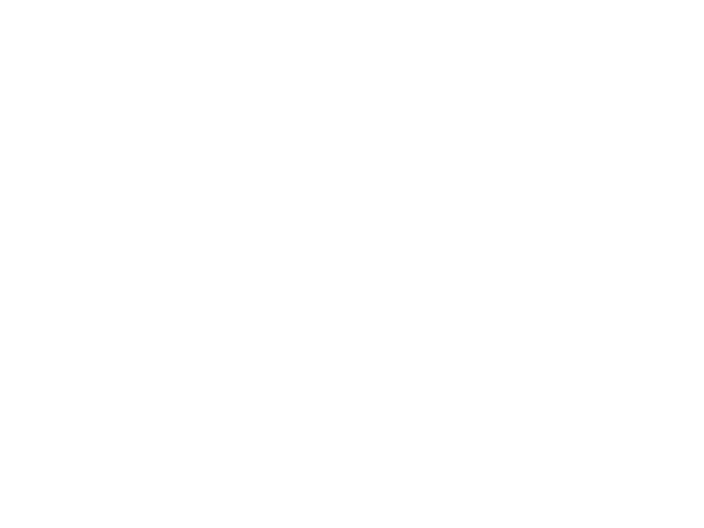

In [17]:
# plot rewards
plt.figure()
df_online, df = load_stats_ddpg(agent)
sns.regplot(x="step", y="rewards", data=df_online, order=1)

In [19]:
# monthly growth
portfolio_return = (1+df_online.rewards[-100:].mean())

returns = task.unwrapped.src.data[0,:,:1]
market_return = (1+returns).mean()
market_return, portfolio_return

(1.0116689, 0.9972954897680569)

# Test

In [20]:
def test_algo(env, algo, seed=0):
    """
    Runs and algo from https://github.com/Marigold/universal-portfolios on env
    
    https://github.com/Marigold/universal-portfolios/commit/e8970a82427522ef11b1c3cbf681e18b5fe8169c
    """
    env.seed(0)
    np.random.seed(0)

    state = env.reset()
    for i in range(env.unwrapped.sim.steps):
        
        history= pd.DataFrame(state[0,:,:], columns=env.unwrapped.src.asset_names)
        # MPT wants a cash column, and it should be first
        history['CASH']=1
        history=history[['CASH'] + env.unwrapped.src.asset_names]
#         cols = list(history.columns)
#         cols[0]='CASH'
#         history.columns = cols
        
        x=history.iloc[-1]
        
        last_b = env.unwrapped.sim.w0#[1:]

        algo.init_step(history)
        # some don't want history
        try:
            action = algo.step(x, last_b, history)
        except TypeError:
            action = algo.step(x, last_b)
        
        # might by dataframe
        action = getattr(action, 'value', action)
        
        # For upt
        if isinstance(action, np.matrixlib.defmatrix.matrix):
            action = np.array(action.tolist()).T[0]
            
        

        state, reward, done, info = env.step(action)

        if done:
            break   
    df = pd.DataFrame(env.unwrapped.infos)
    df.index = pd.to_datetime(df['date']*1e9)
    return df['portfolio_value'], df

<IPython.core.display.Javascript object>


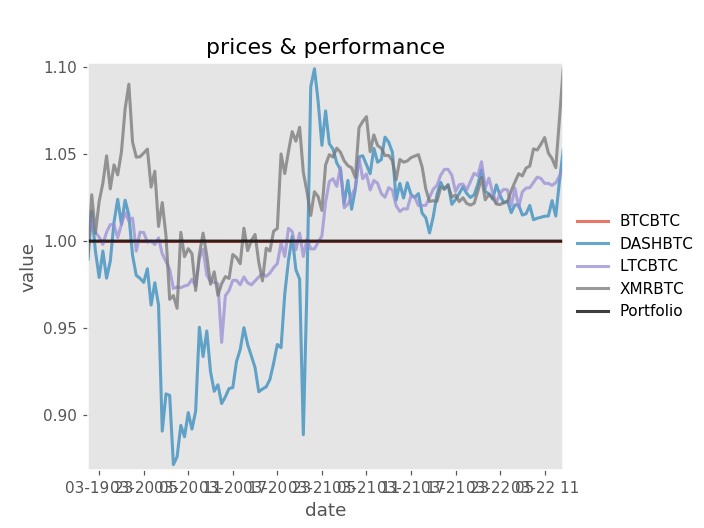

<IPython.core.display.Javascript object>


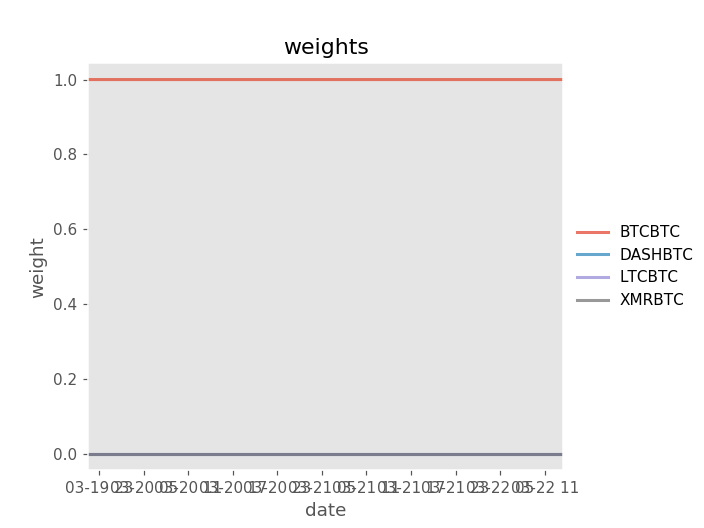

<IPython.core.display.Javascript object>


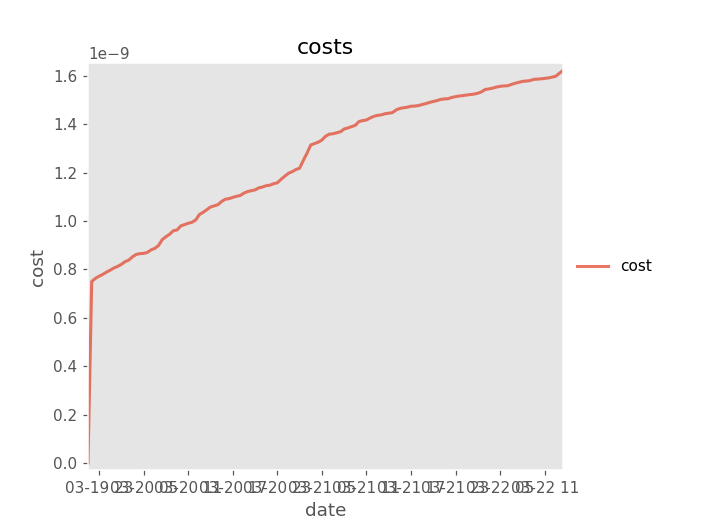

In [21]:
# use test env
df_test = pd.read_hdf('./data/poloniex_30m.hf',key='test')
test_steps=5000
env_test = task_fn_test()
agent.task = env_test
agent.config.max_episode_length = test_steps
agent.task.reset()
np.random.seed(0)

# run in deterministic mode, no training, no exploration
agent.episode(True)
agent.task.render('notebook')
agent.task.render('notebook', True)

df = pd.DataFrame(agent.task.unwrapped.infos)
df.index = pd.to_datetime(df['date']*1e9)

/home/wassname/.pyenv/versions/3.5.3/envs/jupyter3/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


ONS
BestSoFar
RMR


<IPython.core.display.Javascript object>


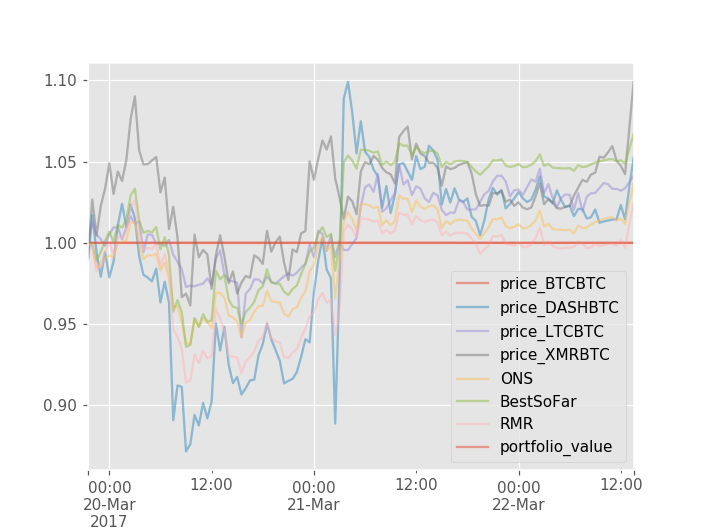

In [22]:
from universal import algos
env = task.unwrapped
price_cols = [col for col in df.columns if col.startswith('price')]
for col in price_cols:
    df[col]=df[col].cumprod()

df = df[price_cols + ['portfolio_value']]
    
algo_dict=dict(
    # Pick the same is in https://arxiv.org/pdf/1706.10059.pdf
    # Benchmarks
#     UCRP=algos.UP(),
    
    # Follow the winner
    BestSoFar=algos.BestSoFar(cov_window=env_test.unwrapped.src.window_length-1),
#     UniversalPortfolio=algos.UP(eval_points=1000),
    ONS=algos.ONS(),
    
    # Follow the loser
#     OnlineMovingAverageReversion=algos.OLMAR(window=env.src.window_length-1, eps=10), 
    RMR=algos.RMR(window=env_test.unwrapped.src.window_length-1, eps=10),
#     PassiveAggressiveMeanReversion=algos.PAMR(),
    
    # Pattern matching
    #     CorrelationDrivenNonparametricLearning=algos.CORN(window=30),
)
for name, algo in algo_dict.items():
    print(name)
    perf, _ = test_algo(env_test, algo)
    perf.index=df.index
    df[name]=perf

# put portfolio value at end so we plot it on top and can therefore see it
cols = list(df.columns.drop('portfolio_value'))+['portfolio_value']
df=df[cols]


df.plot(alpha=0.5)